In [122]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
import numpy as np
import random
import serial
import time

In [156]:
#initialize serial port
ser = serial.Serial()
ser.port = 'COM3' #Arduino serial port
ser.baudrate = 256000
ser.timeout = 10 #specify timeout when using readline()
ser.open()
if ser.is_open==True:
	print("\nAll right, serial port now open. Configuration:\n")
	# print(ser, "\n") #print serial parameters

numofreads = 0
read_time = 5 # in sec

time.sleep(10) # wait until initialization of board
start_time = time.time()
lines = []
ser.reset_input_buffer()
while time.time() - start_time <=  read_time:
    line = ser.readline()              #ascii
    lines.append(line)

for line in lines:
    line_as_list = line.split(b',')
    if not numofreads:
        columns_num = len(line_as_list)
        vals = np.zeros((0,columns_num))
    numofreads += 1
    val = np.zeros((1,columns_num))[0]
    for i in range(columns_num):
        if i==columns_num-1:
            val[i] = line_as_list[i].split(b';')[0]
        else:
            val[i] = float(line_as_list[i])
    vals = np.vstack((vals,val))
print("number of readings: {}".format(numofreads))
print("average time on one reading: {} msec".format(read_time*1e3/numofreads))

ser.close()

t = (vals[:,0]-vals[0,0])*1e-3*0.1220703125
angle_motion = vals[:,1]*0.2932551319648094
angle_mode = vals[:,2]*0.2932551319648094


All right, serial port now open. Configuration:

number of readings: 253
average time on one reading: 19.76284584980237 msec


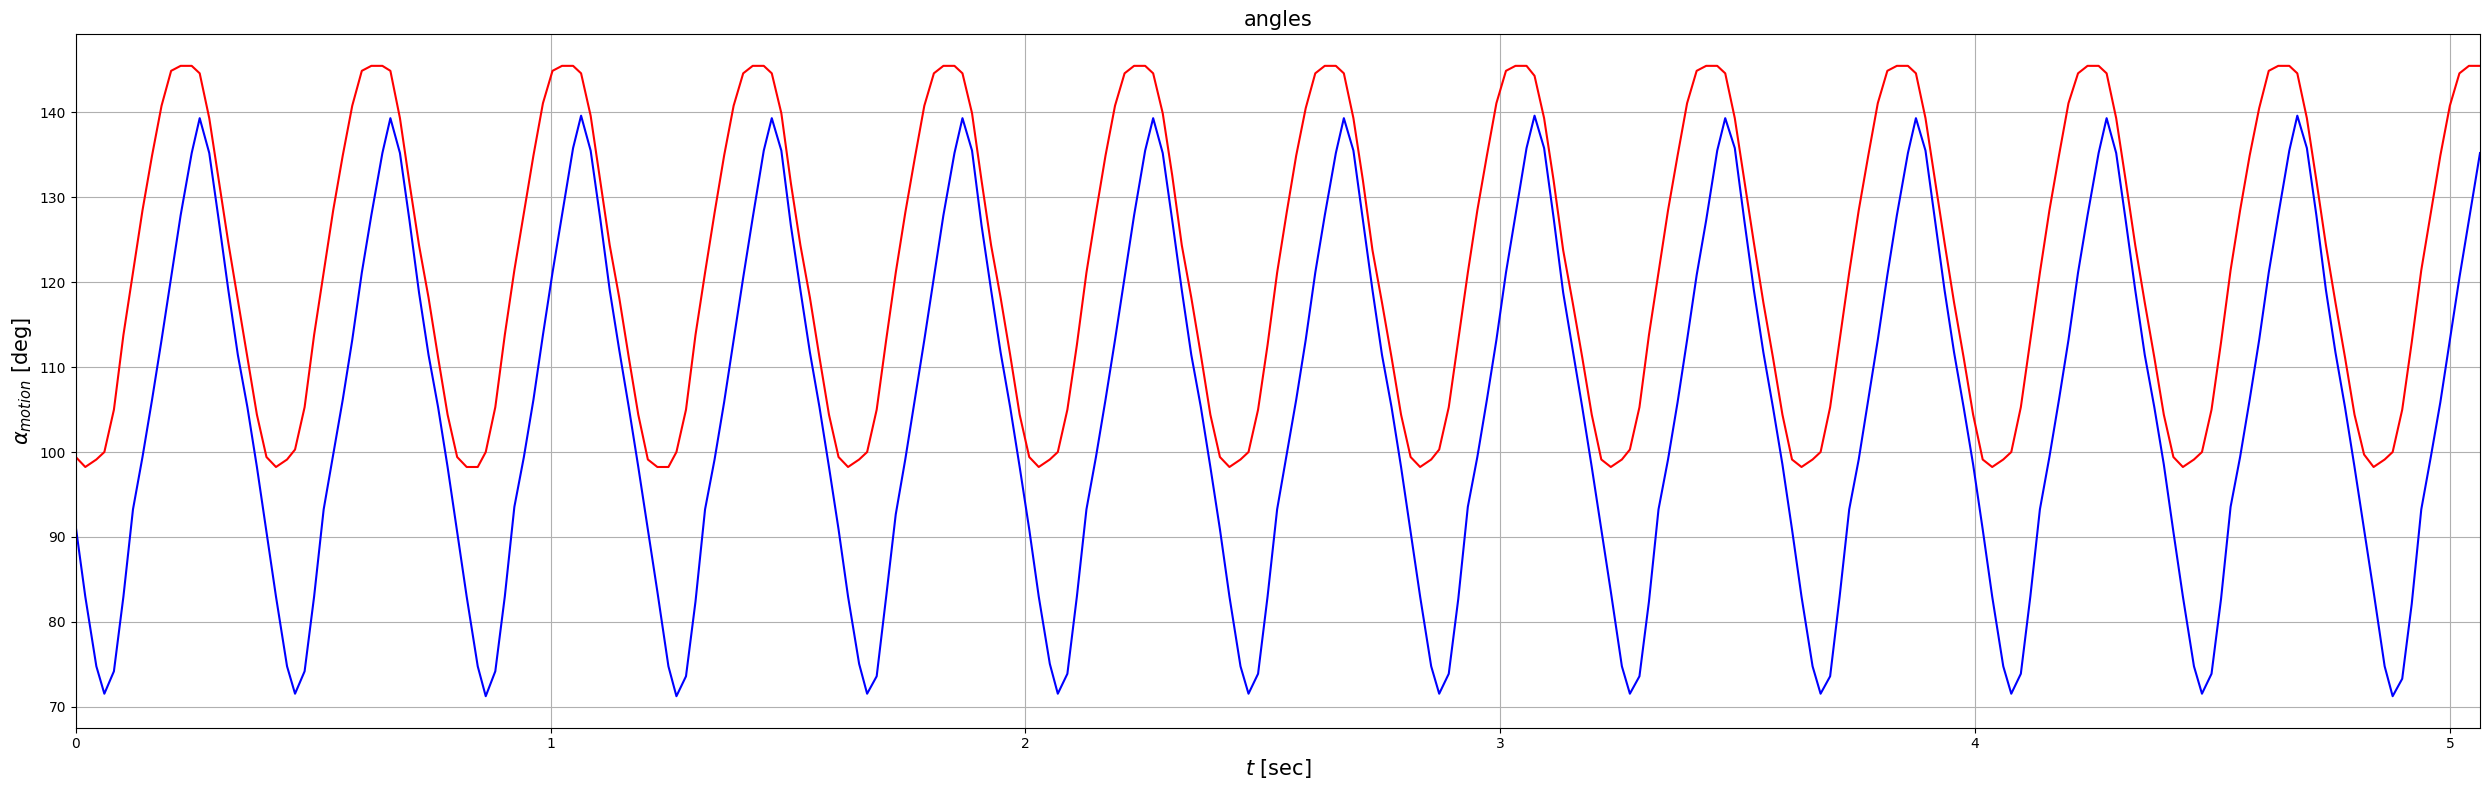

In [157]:
plt.figure(figsize = (25,8))
plt.plot(t,angle_motion,"-b")
plt.plot(t,angle_mode,"-r")
plt.title("angles",fontsize=15)
plt.xlabel("$t$ [sec]",fontsize=15)
plt.ylabel("$\\alpha_{motion}$ [deg]",fontsize=15)
plt.grid(True)
plt.xlim([0 ,t[-1]])
plt.tight_layout()
plt.show()

In [ ]:
# plt.subplots(2,1,figsize = (20,6))
# plt.subplot(211)

# plt.subplot(212)
# plt.plot(self.x_phi_true,self.y_phi_true)
# plt.axis('equal')
# plt.title("given beam shape (x,y)",fontsize=15)
# plt.xlabel("$x$ [mm]",fontsize=15)
# plt.ylabel("$y$ [mm]",fontsize=15)
# plt.grid(True)